# CS5242 Final Project Report
> Group 39
>
> Members: Zhang Xinran(A0250684B), Huang Wenzheng(A0242116U), Chen Yi(A0232299X)

## Report Structure

1. Introduction
2. Dataset
3. Data Preprocessing
4. Model
5. Evaluation









# 1.Introduction

Governments and organizations are costing immense human, financial and material resources to recycle garbage. To make recycling easier and more efficient, we come up with an idea of using deep learning techniques to automate garbage classification. Garbage will be classified into a few classes. Then the recyclables will be automatically packed and sent to recycle factories and finally become useful products again.

In this task, we apply the deep learning method to usual garbage classification.

1. Data collection: Build a dataset of 7 classes of usual garbage: paper, cardboard, can, glass bottle, plastic bottle, plastic bag and battery using Flickr API. Each class contains 500 pictures.
2. Data preprocessing: Manually clean the dataset and implement data normalization and data augmentation. Split the dataset into train dataset and test dataset.
3. Classification: Design and train MLP, CNN, RNN models to classify garbage, including a baseline model and several improvements.
4. Analysis and conclusion: Analyze the differences and reasons among the performance of different models. Give further improvement plans.

# 2.Dataset

The images for triaining are downloaded using Flickr API.

Following the data colelction showcase on tutorial, we first download 1000 links for each class of garbage. Then, we download the image using the link and set a 5 second interval between consecutive download to avoid being blocked. 

In [ ]:
import os
import time
import requests
import pandas as pd
from tqdm import tqdm
from flickrapi import FlickrAPI
from torchvision.models import vgg19_bn

key = 'xxxxxx' 
secret = 'xxxxxx'

In [ ]:
def fetch_image_link(query):
    flickr = FlickrAPI(key, secret) #initialize python flickr api
    photos = flickr.walk(text=query, 
                         tag_mode='all',
                         extras='url_c', #specify meta data to be fetched
                         sort='relevance')   #sort search result based on relevance (high to low by default)

    max_count = 1000   #let's just simply fetch 5 images for illustration
    urls = []
    count = 0

    for photo in photos:
        if count < max_count:
            count = count + 1
            #print("Fetching url for image number {}".format(count))
            try:
                url = photo.get('url_c')
                urls.append(url)
            except:
                print("Url for image number {} could not be fetched".format(count))
        else:
            print(f"Done fetching {query} urls, fetched {len(urls)} urls out of {max_count}")
            break
    return urls
    
QURIES = ['cardboard', 'paper', 'can', 'glass bottle', 'plastic bottle', 'plastic bag', 'battery']    #specify search query
for query in QURIES:
    urls = fetch_image_link(query)
    print('example url:', urls[0])
    urls = pd.Series(urls)
    save_path = './Flickr_scrape/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    category_path = f'{save_path}/{query}_urls.csv'
    print(f"Writing {query} urls to {category_path}")
    urls.to_csv(category_path)

In [ ]:
import time
def fetch_files_with_link(url_path):
    with open(url_path, newline="") as csvfile:
        urls = pd.read_csv(url_path, delimiter=',')
        urls = urls.iloc[:, 1].to_dict().values()
        
    SAVE_PATH = os.path.join(url_path.replace('_urls.csv', ''))
    if not os.path.isdir(SAVE_PATH):
        os.mkdir(SAVE_PATH) #define image storage path
    fail_list = []
    for idx, url in tqdm(enumerate(urls), total=len(urls)):
        # print("Starting download {} of ".format(url[0] + 1), len(urls))
        try:
            resp = requests.get(url, stream=True)   #request file using url
            path_to_write = os.path.join(SAVE_PATH, f"{idx}_" + url.split("/")[-1])
            outfile = open(path_to_write, 'wb')
            outfile.write(resp.content) #save file content
            outfile.close()
            #print("Done downloading {} of {}".format(idx + 1, len(urls)))
        except:
#             print("Failed to download url number {}".format(idx)) 
            fail_list.append(idx)
            
        time.sleep(5)
        
    print(f"Done with {url_path} download, images are saved in {SAVE_PATH}. Fail idx: {fail_list}")

print("Start downloading images...")


CATEGORIES = ['cardboard', 'paper', 'can', 'glass bottle', 'plastic bottle', 'plastic bag', 'battery']    #specify search query
save_path = './Flickr_scrape'
for category in CATEGORIES:
    url_path = f'{save_path}/{category}_urls.csv'
    fetch_files_with_link(url_path)

Then we explore the images. The numbers of images from each category are around 900 due to empty `url_c` attribute in Flickr. Moveover, the quality of the images is not good enough. For example, images of plastic bottle also contain plastic bag and glass bottle, the target garbage only takes up a very small part of the image and some images are totally irrelevant to the category. Therefore, we crop the image to center the target garbage and remove the irrelevant images manually. Finally, we get the following image dataset:

|category|count|
|--------|-----|
|battery|100|
|can|100|
|cardboard|164|
|glass bottle|127|
|paper|122|
|plastic bag|261|
|plastic bottle|120|
|total|994|

The link to [dataset](https://drive.google.com/file/d/1NB6vMggh4xksMjlop0JaYI-5_dvbPXVy/view?usp=share_link).


# 3.Data preprocssing

In this section, we split the dataset into a train dataset and a test dataset and apply normalization and augmentation to the dataset.

In data splitting, we first set a ratio(0.2) for the test dataset. Then for each category, we randomly select part of the images as test data. Others become train data.

Train dataset:

|category|count|
|--------|-----|
|battery|80|
|can|80|
|cardboard|132|
|glass bottle|102|
|paper|98|
|plastic bag|209|
|plastic bottle|96|
|total|797|

Test dataset:

|category|count|
|--------|-----|
|battery|20|
|can|20|
|cardboard|32|
|glass bottle|25|
|paper|24|
|plastic bag|52|
|plastic bottle|24|
|total|197|

Then for each imags in train dataset and test dataset, we apply 3 random transformation(`transforms.RandomPerspective`, `transforms.RandomRotation`, and `transforms.RandomAffine`) to do data augmentation. Each random transformation is performed twice. 

Train dataset after augmentation:

|category|count|
|--------|-----|
|battery|560|
|can|560|
|cardboard|924|
|glass bottle|714|
|paper|686|
|plastic bag|1463|
|plastic bottle|679|
|total|5579|

Test dataset after augmentation:

|category|count|
|--------|-----|
|battery|140|
|can|140|
|cardboard|224|
|glass bottle|175|
|paper|168|
|plastic bag|364|
|plastic bottle|168|
|total|1379|

In order to get uniform dataset for training and testing, we save the dataset into disk after augmentation.

Link to augmented dataset: [train dataset](https://drive.google.com/file/d/1s9xOvOWS9nV4oelKYUEZ9HpQaYzcDi_s/view?usp=sharing), [test dataset](https://drive.google.com/file/d/19SgJK2kVqpErdjcXmLJwoT1EUD03bgiz/view?usp=sharing).

Then we apply formula $x'=\frac{x-μ}{σ}$ to do normalization.

In [ ]:
# unzip the dataset if needed
#!cd drive/MyDrive/CS5242\ final\ project && unzip datase.zip

In [ ]:
# !pip install -q --upgrade torch_snippets
from glob import glob
import os
from torch_snippets import *
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

AUGMENTED_DATASET_PATH = "augmented/augmented_dataset"
AUGMENTED_TRAIN_DATASET_PATH = AUGMENTED_DATASET_PATH + "_train"
AUGMENTED_TEST_DATASET_PATH = AUGMENTED_DATASET_PATH + "_test"

IMAGE_ROOT = 'dataset'
CATEGORIES = [
  'battery', 
  'can', 
  'cardboard', 
  'glass bottle', 
  'paper', 
  'plastic bag', 
  'plastic bottle'
]

In [ ]:
data = {'imageID': [], 'category': [], 'size': [], 'ratio': []}
for category in CATEGORIES:
  for path in glob(f'{IMAGE_ROOT}/{category}/*.*'):
    data['imageID'].append(path.split('/')[-1].split('\\')[-1].split('.')[0])
    data['category'].append(category)
    data['size'].append(0.0)
    data['ratio'].append(0.0)

df = pd.DataFrame(data=data)

def print_df_stat(df):
  print(f"The number of all images: {df['imageID'].count()}.")
  print(df.groupby(['category'])['imageID'].count())

print_df_stat(df)

The number of all images: 994.

category
battery           100
can               100
cardboard         164
glass bottle      127
paper             122
plastic bag       261
plastic bottle    120
Name: imageID, dtype: int64

In [ ]:
TEST_SIZE = 0.2
RANDOM_STATE = 1

def split_data(df, test_size=TEST_SIZE):
  df_train = None
  df_test = None
  train_idx = []
  test_idx = []
  for category in CATEGORIES:
    df_category = df[df['category']==category]
    count = df_category['imageID'].count()
    sample_num = int(count * test_size)
    test = list(df_category.sample(sample_num, random_state=RANDOM_STATE).index)
    train = list(df_category.drop(test).index)
    
    test_idx.extend(test)
    train_idx.extend(train)
  df_train = df.drop(test_idx)
  df_test = df.drop(train_idx)
  return df_train, df_test

df_train, df_test = split_data(df)
print("train data stat:")
print_df_stat(df_train)
print("\n")
print("test data stat:")
print_df_stat(df_test)

train data stat:

The number of all images: 797.

category
battery            80
can                80
cardboard         132
glass bottle      102
paper              98
plastic bag       209
plastic bottle     96
Name: imageID, dtype: int64

test data stat:

The number of all images: 197.

category
battery           20
can               20
cardboard         32
glass bottle      25
paper             24
plastic bag       52
plastic bottle    24
Name: imageID, dtype: int64

In [ ]:
def random_perspective(img, cnt):
  transform = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0)
  ])
  imgs = torch.cat([transform(img).unsqueeze(0) for _ in range(cnt)]).to(device).float()
  return imgs

def random_rotation(img, cnt):
  transform = transforms.Compose([
    transforms.RandomRotation(degrees=(0, 150))
  ])
  imgs = torch.cat([transform(img).unsqueeze(0) for _ in range(cnt)]).to(device).float()
  return imgs

def random_affine(img, cnt):
  transform = transforms.Compose([
    transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3))
  ])
  imgs = torch.cat([transform(img).unsqueeze(0) for _ in range(cnt)]).to(device).float()
  return imgs

def augmentation(img, perspective_cnt=3, rotation_cnt=3, affine_cnt=3):
  return torch.cat([random_perspective(img, perspective_cnt), \
    random_rotation(img, rotation_cnt), random_affine(img, affine_cnt)])

def preprocess_image(img):
  # print(img.shape)
  img = cv2.resize(img, (224, 224))
  transform = transforms.Compose([
    transforms.ToTensor()
  ])
  img_tr = transform(img)
  return img_tr

In [ ]:
class OpenImages(Dataset):
  def __init__(self, df, image_folder=IMAGE_ROOT):
    self.root = image_folder
    self.df = df
    self.unique_images = df['imageID'].unique()
    self.categories = df['category'].tolist()

  def __len__(self):
    return len(self.unique_images)

  def __getitem__(self, ix):
    image_id = self.unique_images[ix]
    category = self.categories[ix]
    image_path = f"{self.root}/{category}/{image_id}.jpg"
    image = cv2.imread(image_path)[...,::-1]
    # print(image_path)
    image = preprocess_image(image)
    label = label2target[category]
    return image, label

train_ds = OpenImages(df_train)
test_ds = OpenImages(df_test)

In [ ]:
# augment dataset & save to disk
def make_path(path):
  os.makedirs(path, exist_ok=True)
  for c in CATEGORIES:
    p = path + f"/{c}"
    os.makedirs(p, exist_ok=True)

make_path(AUGMENTED_TRAIN_DATASET_PATH)
make_path(AUGMENTED_TEST_DATASET_PATH)

for idx, (img, label) in enumerate(train_ds):
  cnts = [2, 2, 2]
  imgs = torch.cat([img.unsqueeze(0).to(device).float(), augmentation(img, *cnts)])
  category = target2label[label]
  for inner_idx, augmented_img in enumerate(imgs):
    path = f"{AUGMENTED_TRAIN_DATASET_PATH}/{category}/{idx}_{inner_idx}.jpg"
    save_image(augmented_img, path)
    # print(path)

for idx, (img, label) in enumerate(test_ds):
  cnts = [2, 2, 2]
  imgs = torch.cat([img.unsqueeze(0).to(device).float(), augmentation(img, *cnts)])
  category = target2label[label]
  for inner_idx, augmented_img in enumerate(imgs):
    path = f"{AUGMENTED_TEST_DATASET_PATH}/{category}/{idx}_{inner_idx+1}.jpg"
    save_image(augmented_img, path)
    # print(path)

In [ ]:
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Lambda(lambd=lambda x:x/255),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Lambda(lambd=lambda x:x.to(device).float()),
])
train_ds = datasets.ImageFolder(AUGMENTED_TRAIN_DATASET_PATH, transform=transform)
test_ds = datasets.ImageFolder(AUGMENTED_TEST_DATASET_PATH, transform=transform)

In [ ]:
train_ds[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
train_loader = DataLoader(train_ds, batch_size=32, drop_last=True, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, drop_last=True, shuffle=True)

# 4.Model

In this section, we train and test different models.

The following cells define some variables and functions for training nad testing.

In [ ]:
# uncomment if torch_snippets not installed
#!pip install -q --upgrade torch_snippets
from torch_snippets import *
from torchvision import models
import gc

AUGMENTED_DATASET_PATH = "augmented/augmented_dataset"
AUGMENTED_TRAIN_DATASET_PATH = AUGMENTED_DATASET_PATH + "_train"
AUGMENTED_TEST_DATASET_PATH = AUGMENTED_DATASET_PATH + "_test"

CATEGORIES = [
  'battery', 
  'can', 
  'cardboard', 
  'glass bottle', 
  'paper', 
  'plastic bag', 
  'plastic bottle'
]

label2target = {l:t for t,l in enumerate(CATEGORIES)}
target2label = {t:l for l,t in label2target.items()}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def decode(_y):
  _, preds = _y.max(-1)
  return preds
def train_batch(inputs, model, optimizer, criterion):
  input, labels = inputs
  model.train()
  optimizer.zero_grad()
  y = model(input)
  labels = labels.to(device).long()
  loss = criterion(y, labels)
  accs = labels == decode(y)
  loss.backward()
  optimizer.step()
  return loss.detach(), accs.cpu().numpy()
def validate_batch(inputs, model, criterion):
  input, labels = inputs
  with torch.no_grad():
    model.eval()
    y = model(input)
    labels = labels.to(device).long()
    loss = criterion(y, labels)
    accs = labels == decode(y)
  return loss.detach(), accs.cpu().numpy()

def train(model, n_epochs=5, lr=1e-3):
  model = model().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  log = Report(n_epochs)
  for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
      loss, accs = train_batch(inputs, model, optimizer, criterion)
      pos = (epoch + (ix+1)/_n)
      log.record(pos, trn_loss=loss.item(), trn_acc=accs.mean(), end='\r')
          
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
      loss, accs = validate_batch(inputs, model, criterion)
      pos = (epoch + (ix+1)/_n)
      log.record(pos, val_loss=loss.item(), val_acc=accs.mean(), end='\r')
  
  last_epoch_trn_acc = []
  for pos, v in log.trn_acc:
    if epoch - pos < 1:
      last_epoch_trn_acc.append(v)

  last_epoch_val_acc = []
  for pos, v in log.val_acc:
    if epoch - pos < 1:
      last_epoch_val_acc.append(v)
  
  print("train_acc:", np.mean(last_epoch_trn_acc), "|val_acc:", np.mean(last_epoch_val_acc))
  return log

## 4.1 Model Baseline
*   Three-layer MLP
*   LeNet5
*   VGG
*   ResNet50
*   ResNet50 implemented by Pytorch 


### 4.1.1 Three-layer MLP
##### The three-layer MLP model is implemented as below with 100 hidden layers in between. The input is 64 images with size of 3 * 224 * 224 and the output is probability scores for all the images. The Cross Entropy is used for the Loss calculation. 

##### The Tree-layer MLP Net architecture is as follows:
<div>
<img src="https://drive.google.com/uc?id=1G4a5FCRqdEoCAwOs_ZWFZ-yUUaHkANxg" width="820" height="350"/>
</div>



In [ ]:
# 3-layer MLP
class three_layer_net(nn.Module):

    def __init__(self, input_size=3*224*224 , hidden_size1=500, hidden_size2=500,  output_size=7):
        super(three_layer_net , self).__init__()

        self.layer1 = nn.Linear(  input_size   , hidden_size1  , bias=False  )
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2  , bias=False  )
        self.layer3 = nn.Linear(  hidden_size2 , output_size   , bias=False  )        
        
    def forward(self, x):
        
        x       = x.view(x.shape[0], 3*224*224)
        y       = self.layer1(x)
        y_hat   = F.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = F.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

### 4.1.2 LeNet5
##### LeNet5 is a multi-layer convolution neural network for image classification. It consist two sets of convolutional and average pooling layers, followed by a flattening layer, then two fully-connected layers.

##### The LeNet5 architecture is as follows:
<div>
<img src="https://drive.google.com/uc?id=1z6kJk0b36nFoMd_2v5dAnmwzWR2cddty" width="1000" height="500"/>
</div>


In [ ]:
# LeNet5 architecture 
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1:   3 * 224 x 224  -->    50 x 224 x 224 
        self.conv1 = nn.Conv2d(3,   50,  kernel_size=3,  padding=1 )
        
        # MP1: 50 x 224 x 224 -->    50 x 112 x 112
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   50 x 112 x 112  -->    100 x 112 x 112 
        self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
        # MP2: 100 x 112 x 112 -->    100 x 56 x 56 
        self.pool2 = nn.MaxPool2d(2,2)


        # LL1:   100 x 56 x 56 = 313600 -->  100 
        self.linear1 = nn.Linear(313600, 100)
        
        # LL2:   100  -->  7 
        self.linear2 = nn.Linear(100,7)


    def forward(self, x):

        # CL1
        x = self.conv1(x)
        x = F.relu(x)
        
        # MP1
        x = self.pool1(x)
        
        # CL2
        x = self.conv2(x)
        x = F.relu(x)
        
        # MP2
        x = self.pool2(x)

        # LL1
        x = x.view(-1, 313600)
        x = self.linear1(x)
        x = F.relu(x)
        
        # LL2
        x = self.linear2(x)
    
        return x

### 4.1.3 VGG
##### The VGG network is constructed with very small convolutional filters. It consists conventional layers and fully connected layers. In our project, we implement the VGG with 10 CNN layers followed by 3 FC layers. Relu is used as the non-linear activation function. And max pooling is used to obtain the most prominent features from the previous feature map.

##### The VGG architecture is as follows:
<div>
<img src="https://drive.google.com/uc?id=1IPoZh8BeTUtdjixwzNa9bzYZvfK7IJEB" width="1000" height="450"/>
</div>


In [ ]:
# VGG architecture 
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         3 x 224 x 224 --> 64 x 112 x 112        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 112 x 112 --> 128 x 56 x 56
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 56 x 56 --> 256 x 28 x 28       
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 28 x 28 --> 512 x 14 x 14
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.conv4b = nn.Conv2d(512, 512, kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2,2)

        #block 5:          512 x 14 x 14 --> 1024 x 7 x 7
        self.conv5a = nn.Conv2d(512, 1024, kernel_size=3, padding=1 )
        self.pool5  = nn.MaxPool2d(2,2)

        # linear layers:   1024 x 7 x 7 --> 50176 --> 100352 --> 100352 --> 7
        self.linear1 = nn.Linear(50176, 2048)
        self.linear2 = nn.Linear(2048,2048)
        self.linear3 = nn.Linear(2048, 7)


    def forward(self, x):

        # block 1
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        # block 2
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)

        # block 3
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)

        #block 4
        x = self.conv4a(x)
        x = self.conv4b(x)
        x = F.relu(x)
        x = self.pool4(x)

        #block 5
        x = self.conv5a(x)
        x = F.relu(x)
        x = self.pool5(x)

        # linear layers
        x = x.view(-1, 50176)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x) 
        
        return x

### 4.1.4 ResNet50
##### ResNet introduced residual connections between layers, which helps reduce loss, preserve knowledge gain, and boosts performance during the training phase.
In our project, we implement ResNet-50, which has 50 layers. The building block was modified into a bottleneck design due to concerns over the time taken to train the layers. And this used a stack of 3 layers. By doing so, the higher accuracy can be achieved.

##### Besides, we also build the ResNet50 model implement by Pytorch for comparision purpose.

##### The ResNet50 architecture is as follows:
<div>
<img src="https://drive.google.com/uc?id=15wsRlC0_saQCXEGfpVpeQiNdpVPGk8hJ" width="800" height="400"/>
</div>



In [ ]:
# ResNet50
class MyBottleneck(nn.Module):
    def __init__(self,in_channel,middle_channel,out_channel,downsample,middle_stride,downsample_stride):
        super(MyBottleneck, self).__init__()
        self.if_downsample=downsample

        self.conv1=nn.Conv2d(in_channel,middle_channel,kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.bn1=nn.BatchNorm2d(middle_channel, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2=nn.Conv2d(middle_channel, middle_channel, kernel_size=(3, 3), stride=(middle_stride, middle_stride), padding=(1, 1), bias=False)
        self.bn2= nn.BatchNorm2d(middle_channel, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3=nn.Conv2d(middle_channel, out_channel, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.bn3=nn.BatchNorm2d(out_channel, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu=nn.ReLU(inplace=True)

        if downsample:
            self.downsample=nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=(1, 1), stride=(downsample_stride, downsample_stride), bias=False),
                nn.BatchNorm2d(out_channel, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
        
        nn.init.normal_(self.conv1.weight.data, 0.0, 0.01)
        nn.init.normal_(self.conv2.weight.data, 0.0, 0.01)
        nn.init.normal_(self.conv3.weight.data, 0.0, 0.01)
        nn.init.normal_(self.bn1.weight.data, 1.0, 0.01)
        nn.init.normal_(self.bn2.weight.data, 1.0, 0.01)
        nn.init.normal_(self.bn3.weight.data, 1.0, 0.01)
        if downsample:
          for m in self.downsample.children():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, 0.0, 0.01)
            if isinstance(m,nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, 1.0, 0.01)


    def forward(self,x):
        identity = x
        if self.if_downsample:
            identity = self.downsample(x) 

        x=self.conv1(x)
        x=self.bn1(x)
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.conv3(x)
        x=self.bn3(x)

        x += identity 
        x = self.relu(x)

        return x


class MyResNet50(nn.Module):
    def __init__(self):
        super(MyResNet50, self).__init__()

        self.conv1=nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1=nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu=nn.ReLU(inplace=True)
        self.maxpool=nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.layer1=nn.Sequential(
            MyBottleneck(64,64,256,True,1,1),
            MyBottleneck(256,64,256,False,1,1),
            MyBottleneck(256,64,256,False,1,1),
        )
        
        self.layer2=nn.Sequential(
            MyBottleneck(256,128,512,True,2,2),
            MyBottleneck(512,128,512,False,1,1),
            MyBottleneck(512,128,512,False,1,1),
            MyBottleneck(512,128,512,False,1,1)
        )
        self.layer3=nn.Sequential(
            MyBottleneck(512,256,1024,True,2,2),
            MyBottleneck(1024,256,1024,False,1,1),
            MyBottleneck(1024,256,1024,False,1,1),
            MyBottleneck(1024,256,1024,False,1,1),
            MyBottleneck(1024,256,1024,False,1,1),
            MyBottleneck(1024,256,1024,False,1,1)
        )
        self.layer4=nn.Sequential(
            MyBottleneck(1024,512,2048,True,2,2),
            MyBottleneck(2048,512,2048,False,1,1),
            MyBottleneck(2048,512,2048,False,1,1)
        )

        self.avg_pool=nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc=nn.Linear(in_features=2048, out_features=len(CATEGORIES), bias=True)

    def forward(self,x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.maxpool(x)

        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)

        x=self.avg_pool(x).squeeze()
        x=self.fc(x)
        
        return x

In [ ]:
# ResNet50 implemented by Pytorch       
class ResNet50(nn.Module):
  def __init__(self):
    super(ResNet50, self).__init__()

    self.resnet=models.resnet50(pretrained=True)
    self.fc=nn.Linear(1000, len(CATEGORIES))
    self.relu=nn.ReLU(inplace=True)

  def forward(self,x):
    x=self.resnet(x)
    x=self.relu(x)
    x=self.fc(x)
    
    return x

###4.1.5 Baseline Training Result 

##### n_epochs  and lr have been selected for the best performance under each model. And the final performance result among the models are as following table:
<div>
<img src="https://drive.google.com/uc?id=14aOjaFAKUWfEIDbSfd5IHMzM3P6o6n9q" width="450" height="300"/>
</div>

##### Among them ResNet-50 implemented by Pytorch performs the best. The reason ResNet-50 implemented by us performs worser than the ResNet-50 implemented by Pytorch is because later is a pretrained version of the network trained on more than a million images. As a result, the network has better performance with learned rich feature representations.


EPOCH: 50.000  val_loss: 1.973  val_acc: 0.344  (1485.38s - 0.00s remaining)

train_acc: 0.9592313218390804 |val_acc: 0.36700581395348836

100%|███████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 370.18it/s]


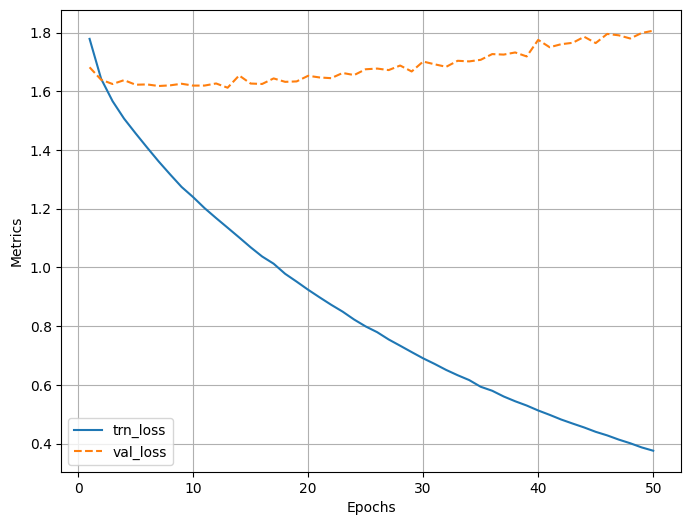

100%|███████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 426.53it/s]


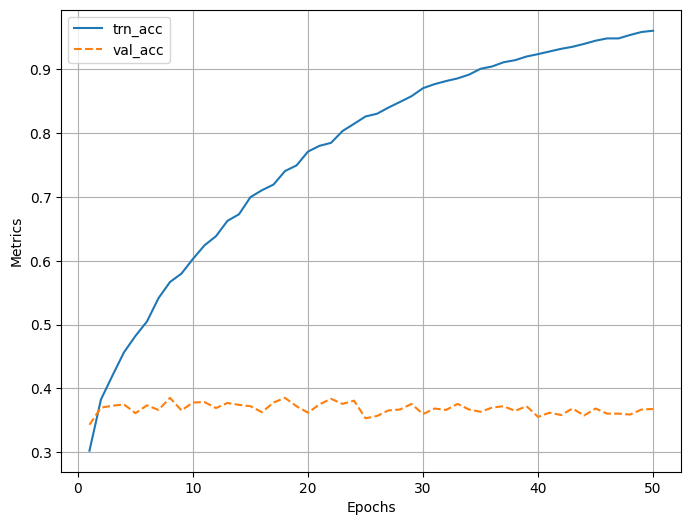

In [ ]:
# three_layer_net
log = train(three_layer_net, 50, 1e-6)
log.plot_epochs('trn_loss,val_loss'.split(','))
log.plot_epochs('trn_acc,val_acc'.split(','))

EPOCH: 30.000  val_loss: 1.631  val_acc: 0.500  (1435.73s - 0.00s remaining)

train_acc: 0.9310344827586207 |val_acc: 0.41933139534883723

100%|███████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 619.44it/s]


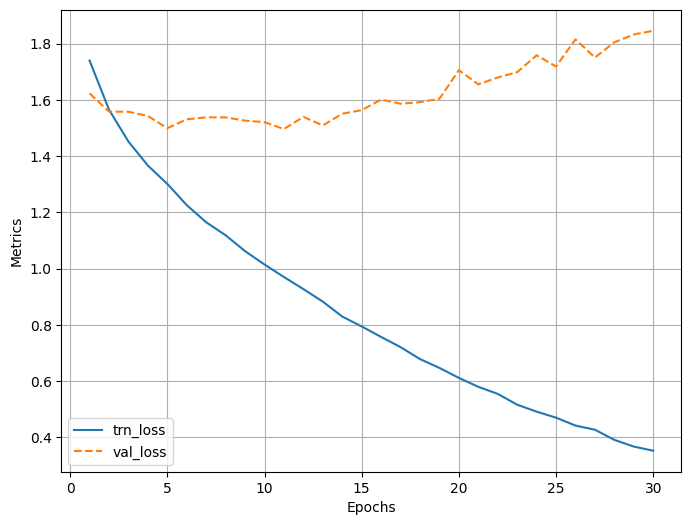

100%|███████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 637.58it/s]


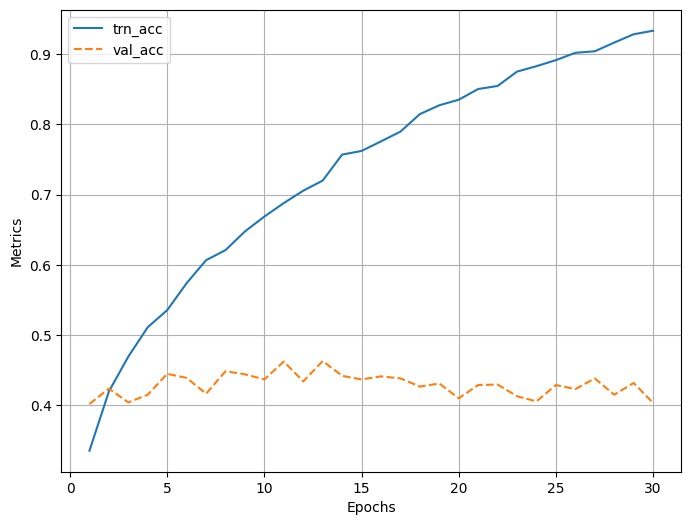

In [ ]:
# LeNet5_convnet
log = train(LeNet5_convnet, 30, 1e-5)
log.plot_epochs('trn_loss,val_loss'.split(','))
log.plot_epochs('trn_acc,val_acc'.split(','))

EPOCH: 10.000  val_loss: 2.952  val_acc: 0.312  (1618.69s - 0.00s remaining)

train_acc: 0.7133620689655172 |val_acc: 0.48074127906976744

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1080.59it/s]


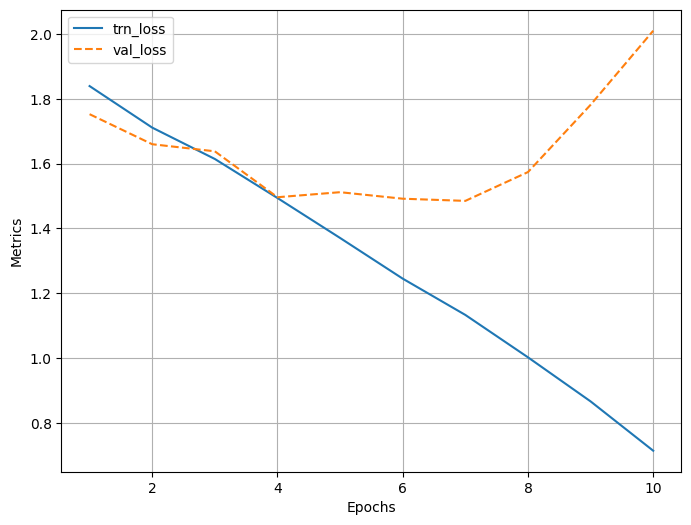

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1523.69it/s]


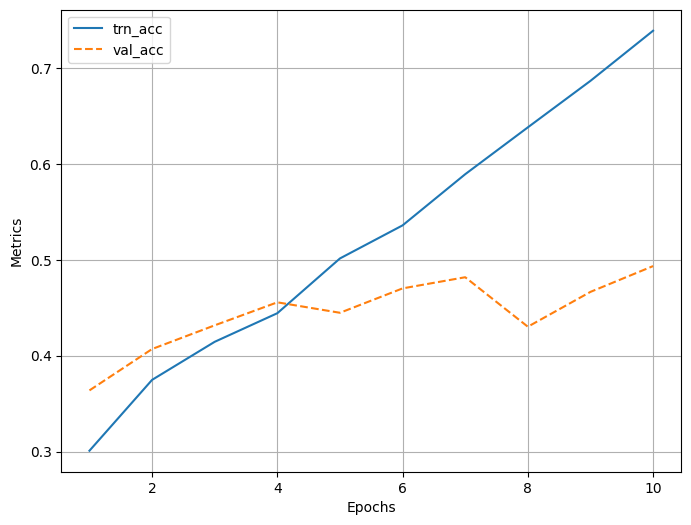

In [ ]:
# VGG_convnet
log = train(VGG_convnet, 10, 5e-5)
log.plot_epochs('trn_loss,val_loss'.split(','))
log.plot_epochs('trn_acc,val_acc'.split(','))


EPOCH: 20.000  val_loss: 1.621  val_acc: 0.469  (2519.37s - 0.00s remaining)

train_acc: 0.8126795977011494 |val_acc: 0.5174418604651163

100%|███████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 848.12it/s]


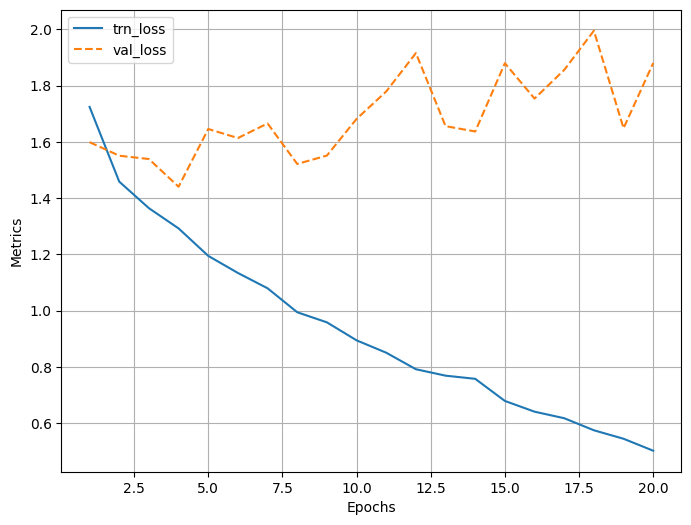

100%|███████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 586.18it/s]


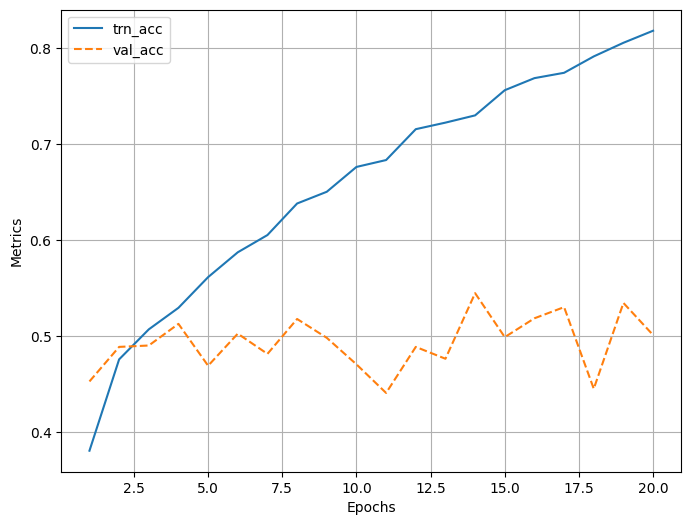

In [ ]:
# MyResNet50 
log = train(MyResNet50, 20, 1e-4)
log.plot_epochs('trn_loss,val_loss'.split(','))
log.plot_epochs('trn_acc,val_acc'.split(','))

D:\applications\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH: 5.000  val_loss: 0.322  val_acc: 0.875  (655.92s - 0.00s remaining)

train_acc: 0.9957794540229885 |val_acc: 0.8619186046511628

100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 2168.84it/s]


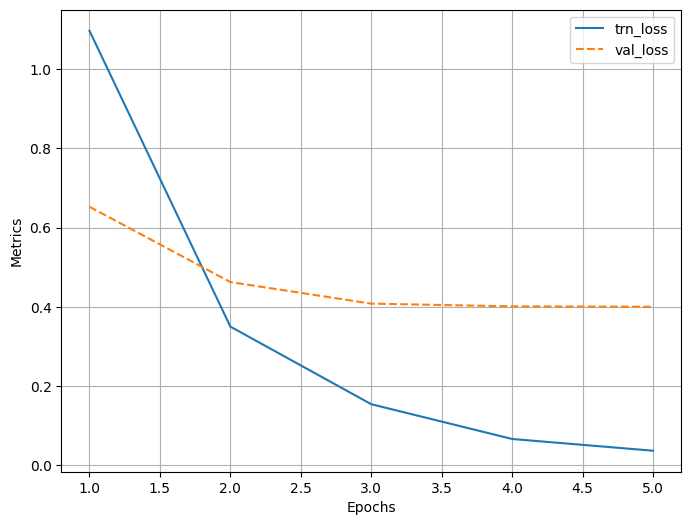

100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 2471.74it/s]


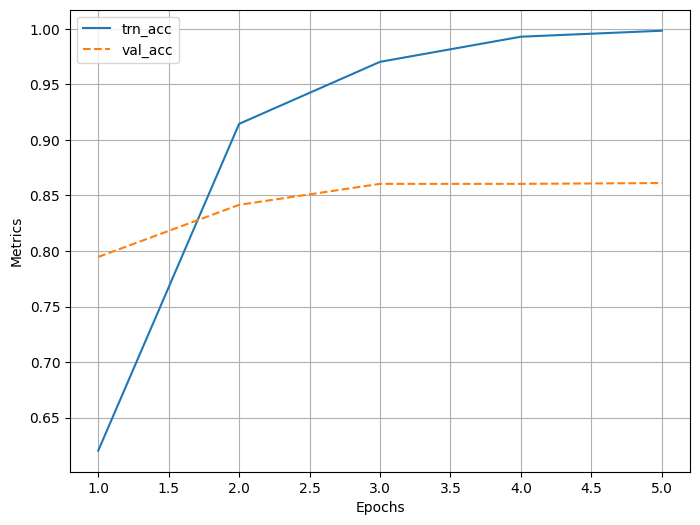

In [ ]:
# ResNet50 
log = train(ResNet50, 5, 1e-5)
log.plot_epochs('trn_loss,val_loss'.split(','))
log.plot_epochs('trn_acc,val_acc'.split(','))

## 4.2 Improvements

### 4.2.1 CNN RNN Mixed Model

RNN is a neural network that can utilize context and generate state for each node in serialized data. Image data can also be regarded as serialized data. A imgae of size (224,224) can be treated as serialized data with 224 consecutive rows. Each row is a vector with 224 numbers. 

LSTM is a kind of RNN, which includes a long-term memory cell. It also deals with vanishing and exploding gradient problem by introducing different gates.

Therefore, we try to improve our model by adding an LSTM model. The convolutiuon parts remain unchanged. The input data go through several convolution layers and is flattened . Then the input data also go through an LSTM model and is also flattened. Then the CNN and LSTM features are stacked together, which forms a new input data of another fully connected layer. Then the last fully connected layer output 7 numbers as the evaluation score.


![](https://drive.google.com/uc?id=1aLsMej1q-AWcKjudparoDdK4_1gbMbO0)


In [ ]:
class CNN_RNN_Mixed(nn.Module):
  def __init__(self):
    super(CNN_RNN_Mixed, self).__init__()

    self.hidden_size=50
    self.resnet=models.resnet50(pretrained=True)

    self.rnn=nn.LSTM(224, self.hidden_size, batch_first=True)
    self.rnn_fc=nn.Linear(3*224*self.hidden_size, 1000)

    self.fc=nn.Linear(2000, len(CATEGORIES))
    self.relu=nn.ReLU(inplace=True)

  def forward(self,x):
    # x: bs*3*224*224
    bs = x.shape[0]
    cnn_out = self.resnet(x) # bs*1000

    rnn_out = x.view(-1, *x.shape[-2:]) # (bs*3)*224*224
    
    h0 = torch.randn(1, bs*x.shape[1], self.hidden_size).to(device)
    c0 = torch.randn(1, bs*x.shape[1], self.hidden_size).to(device)
    rnn_out, _ = self.rnn(rnn_out, (h0, c0))
    
    rnn_out = rnn_out.view(bs, -1, 224, self.hidden_size) # bs*3*self.hidden_size
    rnn_out = torch.flatten(rnn_out, 1) # bs*(3*224*self.hidden_size)
    rnn_out = self.rnn_fc(rnn_out) # bs*1000

    y = torch.cat((cnn_out, rnn_out), 1) # bs*2000

    y=self.relu(y)
    y=self.fc(y)

    gc.collect()
    torch.cuda.empty_cache()
    
    return y

### Results

Compared to pure CNN model, the CNN RNN mixed model performs a little better. This is probably because long-short-term memory cells successfully capture the inner relationship features between consecutives rows, which contributes to identifying the garbage. 

![](https://drive.google.com/uc?id=1WWzgTvr9tXmm0G1EDfN3junVKt_G7Eb0)

EPOCH: 10.000  val_loss: 0.730  val_acc: 0.750  (1543.61s - 0.00s remaining)

train_acc: 0.999371408045977 |val_acc: 0.8662790697674418

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1070.12it/s]


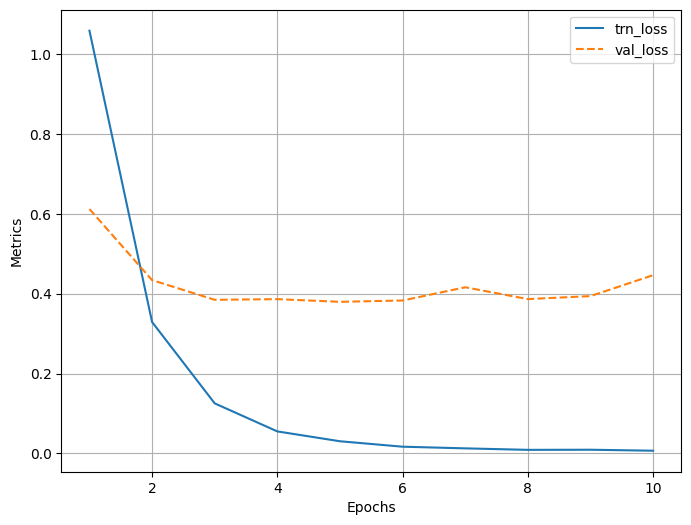

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1250.57it/s]


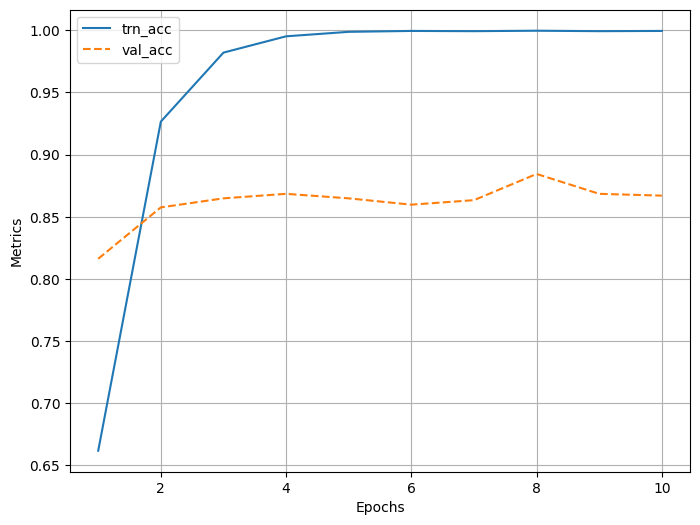

In [ ]:
log = train(CNN_RNN_Mixed, 10, 1e-5)
log.plot_epochs('trn_loss,val_loss'.split(','))
log.plot_epochs('trn_acc,val_acc'.split(','))

### 4.2.2 Attention CNN Model

Convolutional Block Attention Module (CBAM) is an image attention module that combines channel attention and spatial attention in sequential order. It refines the feature map,thus is easy to be inserted into multiple CNN models.
The architecture of CBAM is as the below pictures.   
Channel attention is to exploit the inter-channel relationship. It firstly squeezes the spatial dimensions using max-pooling and avg-pooling respectively, and then uses 2 shared MLP layers to exploit the relationship. We use convolutional layers instead of MLP layers for less parameters in our implementation. The outputs are summed element-wisely and activated by sigmoid.   
Spatial attention uses max pooling and average pooling to squeeze the channel dimensions, then concatenates the 2 features and exploits the inter-spatial relationship using a convolutional layer.  It’s also activated by sigmoid. 

![](https://drive.google.com/uc?id=1sDK1eu98JtEcj65t_q-FJbbh_Js_RuWW)
   
![](https://drive.google.com/uc?id=11hxzbSPRrQpfG-25Ikt3c_E82izlioVg)





We insert it into ResNet50 in this work. CBAM is added into every bottleneck module as shown below. We also experimented CBAM with only channel attention and with only spatial attention to see their difference.

![](https://drive.google.com/uc?id=1252oxHq3JXOE1uAQe2iK4f83IEYlxljk)

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.max_pool = nn.AdaptiveMaxPool2d(output_size=(1,1))
        
        self.model=nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels // ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_channels // ratio, out_channels=in_channels, kernel_size=1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

        for m in self.model.children():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, 0.0, 0.05)

    def forward(self, x):
        avg = self.model(self.avg_pool(x))
        max = self.model(self.max_pool(x))
        result = self.sigmoid(avg + max)
        return result
    

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7)
        if kernel_size==7:
          padding=3
        elif kernel_size==3:
          padding=1
        self.conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

        nn.init.normal_(self.conv.weight.data, 0.0, 0.05)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        x = self.sigmoid(x)
        return x

class cbam(nn.Module):
    def __init__(self, channel, ratio=8, kernel_size=7):
        super(cbam, self).__init__()
        self.ChannelAttention = ChannelAttention(channel, ratio=ratio)
        self.SpatialAttention = SpatialAttention(kernel_size=kernel_size)

    def forward(self, x):
        x = x * self.ChannelAttention(x)
        x = x * self.SpatialAttention(x)
        return x
    
        

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self,layer_num,bottle_num,channel):
        super(Bottleneck, self).__init__()
        
        resnet=models.resnet50(pretrained=True)
        
        if layer_num==1:
            resnet=resnet.layer1
        elif layer_num==2:
            resnet=resnet.layer2
        elif layer_num==3:
            resnet=resnet.layer3
        elif layer_num==4:
            resnet=resnet.layer4
        bottle=resnet[bottle_num]

        self.feature=torch.nn.Sequential(*(list(bottle.children())[:6]))
        self.relu=nn.ReLU(inplace=True)

        self.if_downsample=False
        if bottle_num==0:
            self.if_downsample=True
            self.downsample=torch.nn.Sequential(*(list(bottle.children())[7:]))[0]

        self.attention=cbam(channel)
        
    def forward(self,x):
        identity = x
        if self.if_downsample:
            identity = self.downsample(x) 

        x=self.feature(x)
        att=self.attention(x)
        # x=att*x

        x += identity 
        x = self.relu(x)

        return x

class Bottleneck_ChannelAtt(nn.Module):
    def __init__(self,layer_num,bottle_num,channel):
        super(Bottleneck_ChannelAtt, self).__init__()
        
        resnet=models.resnet50(pretrained=True)
        
        if layer_num==1:
            resnet=resnet.layer1
        elif layer_num==2:
            resnet=resnet.layer2
        elif layer_num==3:
            resnet=resnet.layer3
        elif layer_num==4:
            resnet=resnet.layer4
        bottle=resnet[bottle_num]

        self.feature=torch.nn.Sequential(*(list(bottle.children())[:6]))
        self.relu=nn.ReLU(inplace=True)

        self.if_downsample=False
        if bottle_num==0:
            self.if_downsample=True
            self.downsample=torch.nn.Sequential(*(list(bottle.children())[7:]))[0]

        self.attention=ChannelAttention(channel)
        
    def forward(self,x):
        identity = x
        if self.if_downsample:
            identity = self.downsample(x) 

        x=self.feature(x)
        att=self.attention(x)
        x=att*x

        x += identity 
        x = self.relu(x)

        return x

class Bottleneck_SpatialAtt(nn.Module):
    def __init__(self,layer_num,bottle_num,channel):
        super(Bottleneck_SpatialAtt, self).__init__()
        
        resnet=models.resnet50(pretrained=True)
        
        if layer_num==1:
            resnet=resnet.layer1
        elif layer_num==2:
            resnet=resnet.layer2
        elif layer_num==3:
            resnet=resnet.layer3
        elif layer_num==4:
            resnet=resnet.layer4
        bottle=resnet[bottle_num]

        self.feature=torch.nn.Sequential(*(list(bottle.children())[:6]))
        self.relu=nn.ReLU(inplace=True)

        self.if_downsample=False
        if bottle_num==0:
            self.if_downsample=True
            self.downsample=torch.nn.Sequential(*(list(bottle.children())[7:]))[0]

        self.attention=SpatialAttention()
        
    def forward(self,x):
        identity = x
        if self.if_downsample:
            identity = self.downsample(x) 

        x=self.feature(x)
        att=self.attention(x)
        x=att*x

        x += identity 
        x = self.relu(x)

        return x

# combine resnet50 and cbam
class Attention_ResNet(nn.Module):
    def __init__(self):
        super(Attention_ResNet, self).__init__()

        resnet=models.resnet50(pretrained=True)
        self.layer0=torch.nn.Sequential(*(list(resnet.children())[:4]))
        
        self.layer1=nn.Sequential(
            Bottleneck(1,0,256),
            Bottleneck(1,1,256),
            Bottleneck(1,2,256),
        )
        
        self.layer2=nn.Sequential(
            Bottleneck(2,0,512),
            Bottleneck(2,1,512),
            Bottleneck(2,2,512),
            Bottleneck(2,3,512),
        )
        self.layer3=nn.Sequential(
            Bottleneck(3,0,1024),
            Bottleneck(3,1,1024),
            Bottleneck(3,2,1024),
            Bottleneck(3,3,1024),
            Bottleneck(3,4,1024),
            Bottleneck(3,5,1024),
        )
        self.layer4=nn.Sequential(
            Bottleneck(4,0,2048),
            Bottleneck(4,1,2048),
            Bottleneck(4,2,2048),
        )

        self.avg_pool=nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc1=resnet.fc
        self.fc2=nn.Linear(1000, len(CATEGORIES))
        self.relu=nn.ReLU(inplace=True)
        self.sigmoid=nn.Sigmoid()

    def forward(self,x):
        x=self.layer0(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)

        x=self.avg_pool(x).squeeze()
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        
        x=self.sigmoid(x)
        return x

class ChannelAttention_ResNet(nn.Module):
    def __init__(self):
        super(ChannelAttention_ResNet, self).__init__()

        resnet=models.resnet50(pretrained=True)
        self.layer0=torch.nn.Sequential(*(list(resnet.children())[:4]))
        
        self.layer1=nn.Sequential(
            Bottleneck_ChannelAtt(1,0,256),
            Bottleneck_ChannelAtt(1,1,256),
            Bottleneck_ChannelAtt(1,2,256),
        )
        
        self.layer2=nn.Sequential(
            Bottleneck_ChannelAtt(2,0,512),
            Bottleneck_ChannelAtt(2,1,512),
            Bottleneck_ChannelAtt(2,2,512),
            Bottleneck_ChannelAtt(2,3,512),
        )
        self.layer3=nn.Sequential(
            Bottleneck_ChannelAtt(3,0,1024),
            Bottleneck_ChannelAtt(3,1,1024),
            Bottleneck_ChannelAtt(3,2,1024),
            Bottleneck_ChannelAtt(3,3,1024),
            Bottleneck_ChannelAtt(3,4,1024),
            Bottleneck_ChannelAtt(3,5,1024),
        )
        self.layer4=nn.Sequential(
            Bottleneck_ChannelAtt(4,0,2048),
            Bottleneck_ChannelAtt(4,1,2048),
            Bottleneck_ChannelAtt(4,2,2048),
        )

        self.avg_pool=nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc1=resnet.fc
        self.fc2=nn.Linear(1000, len(CATEGORIES))
        self.relu=nn.ReLU(inplace=True)
        self.sigmoid=nn.Sigmoid()

    def forward(self,x):
        x=self.layer0(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)

        x=self.avg_pool(x).squeeze()
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        
        x=self.sigmoid(x)
        return x

class SpatialAttention_ResNet(nn.Module):
    def __init__(self):
        super(SpatialAttention_ResNet, self).__init__()

        resnet=models.resnet50(pretrained=True)
        self.layer0=torch.nn.Sequential(*(list(resnet.children())[:4]))
        
        self.layer1=nn.Sequential(
            Bottleneck_SpatialAtt(1,0,256),
            Bottleneck_SpatialAtt(1,1,256),
            Bottleneck_SpatialAtt(1,2,256),
        )
        
        self.layer2=nn.Sequential(
            Bottleneck_SpatialAtt(2,0,512),
            Bottleneck_SpatialAtt(2,1,512),
            Bottleneck_SpatialAtt(2,2,512),
            Bottleneck_SpatialAtt(2,3,512),
        )
        self.layer3=nn.Sequential(
            Bottleneck_SpatialAtt(3,0,1024),
            Bottleneck_SpatialAtt(3,1,1024),
            Bottleneck_SpatialAtt(3,2,1024),
            Bottleneck_SpatialAtt(3,3,1024),
            Bottleneck_SpatialAtt(3,4,1024),
            Bottleneck_SpatialAtt(3,5,1024),
        )
        self.layer4=nn.Sequential(
            Bottleneck_SpatialAtt(4,0,2048),
            Bottleneck_SpatialAtt(4,1,2048),
            Bottleneck_SpatialAtt(4,2,2048),
        )

        self.avg_pool=nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc1=resnet.fc
        self.fc2=nn.Linear(1000, len(CATEGORIES))
        self.relu=nn.ReLU(inplace=True)
        self.sigmoid=nn.Sigmoid()

    def forward(self,x):
        x=self.layer0(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)

        x=self.avg_pool(x).squeeze()
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        
        x=self.sigmoid(x)
        return x


### Results

The experiment results are shown below. We also test ChannelAttention only and SpatialAttention only. Although the combination of those 2 attentions performs better, it doesn’t outperform the original ResNet. Possible reasons may include overfitting and negatively enhancing the feature maps.  

![](https://drive.google.com/uc?id=1Y_F-RXiOBzWb3yuBTRbFwrtxA7KF6YJO)

EPOCH: 10.000  val_loss: 1.399  val_acc: 0.781  (1532.18s - 0.00s remaining)

train_acc: 0.9874281609195402 |val_acc: 0.7165697674418605

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1049.97it/s]


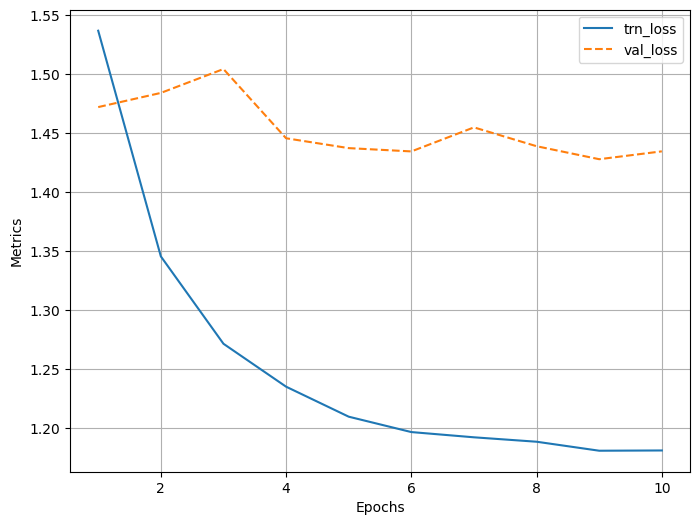

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1478.94it/s]


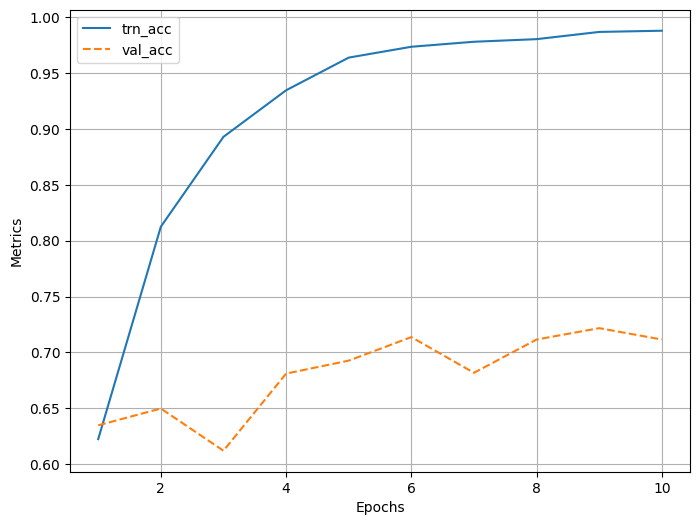

In [ ]:
log = train(Attention_ResNet, 10, 3e-5)
log.plot_epochs('trn_loss,val_loss'.split(','))
log.plot_epochs('trn_acc,val_acc'.split(','))

EPOCH: 10.000  val_loss: 1.598  val_acc: 0.500  (1598.09s - 0.00s remaining)

train_acc: 0.9844647988505747 |val_acc: 0.684593023255814

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1356.71it/s]


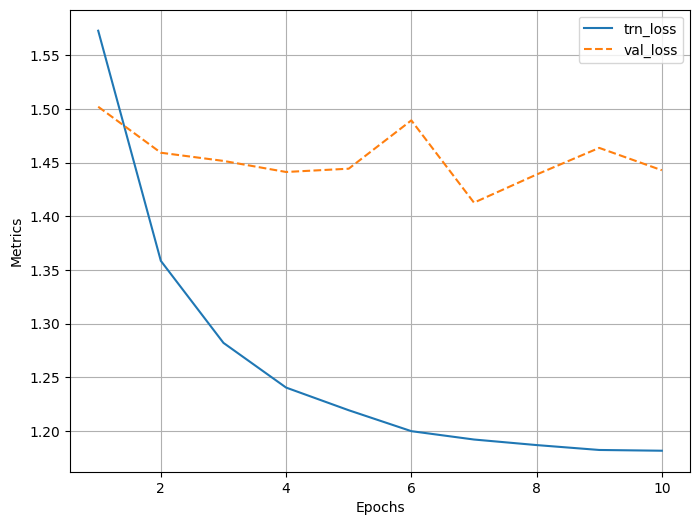

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1686.33it/s]


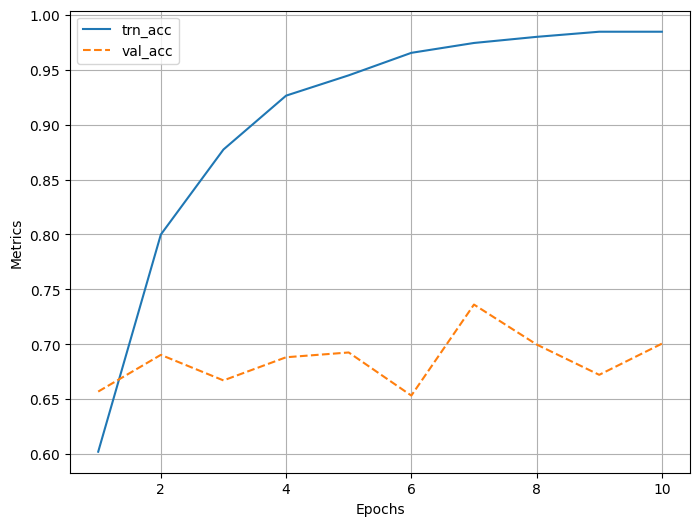

In [ ]:
log = train(ChannelAttention_ResNet, 10, 3e-5)
log.plot_epochs('trn_loss,val_loss'.split(','))
log.plot_epochs('trn_acc,val_acc'.split(','))

EPOCH: 10.000  val_loss: 1.481  val_acc: 0.625  (1421.49s - 0.00s remaining)

train_acc: 0.9807830459770115 |val_acc: 0.6896802325581395

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1340.95it/s]


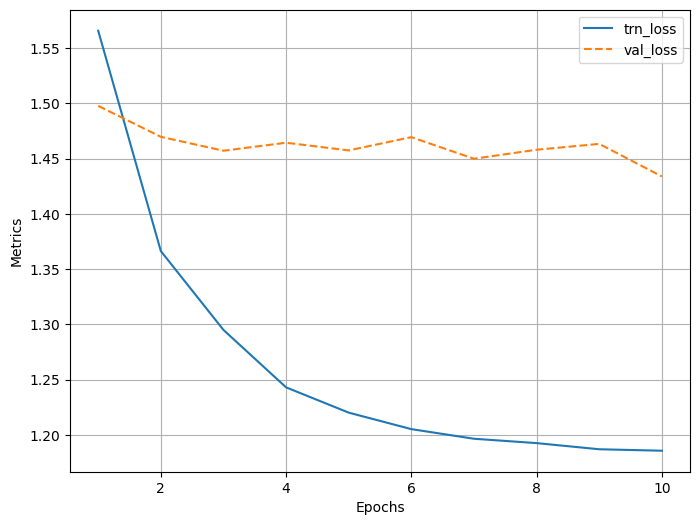

100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1567.59it/s]


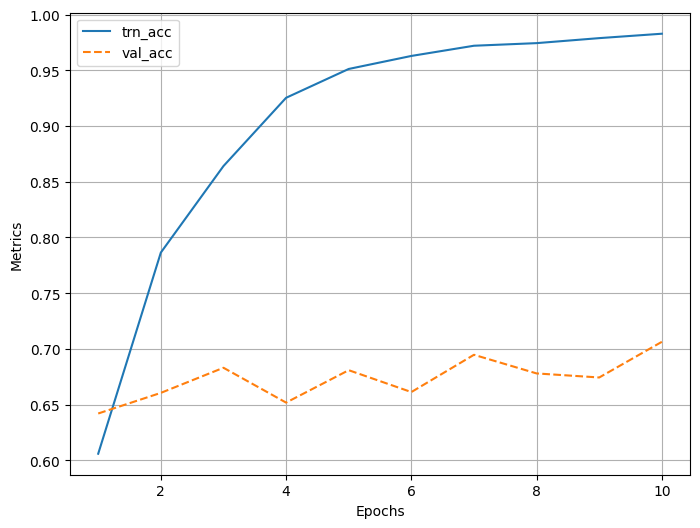

In [ ]:
log = train(SpatialAttention_ResNet, 10, 3e-5)
log.plot_epochs('trn_loss,val_loss'.split(','))
log.plot_epochs('trn_acc,val_acc'.split(','))